# Demo

## Imports

In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB, COLOR_LAB2BGR
import sys
from einops import rearrange

sys.path.append('../')
from scripts import customUNet as unet
from scripts import forward_process as fp, reverse_process as rp, train, util

## Load grayscale image

In [3]:
grayscale_img = cv2.imread("./img/grayscale.jpeg", 0)

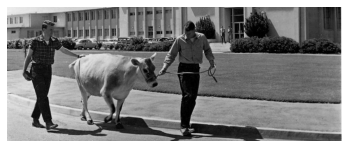

In [4]:
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')

## Let's convert the grayscale image to a Lab tensor

torch.Size([1, 100, 100])

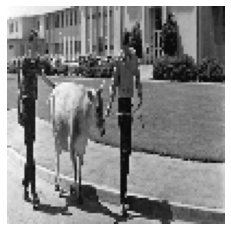

In [5]:
# Normalize & Resize
size=100
grayscale_img = cv2.normalize(grayscale_img, None, alpha = -1, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
grayscale_img = cv2.resize(grayscale_img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

# Convert to a tensor
img = torch.tensor(np.array(grayscale_img))
# Reshape so the tensor has the right shape
gray = rearrange(img,"h w -> 1 h w")

# Let's see how the resized image looks
plt.axis('off')
plt.imshow(np.asarray(gray[0]), cmap='gray')
gray.shape

In [6]:
# Take the L part of the LAB image to have grayscale
gray = rearrange(gray,"b w h-> b w h 1")
gray = gray.expand(gray.shape[0],gray.shape[1],gray.shape[2],3)
gray = rearrange(gray,"b w h c-> b c w h")
gray.shape

torch.Size([1, 3, 100, 100])

## Load model

In [7]:
T = 300
diffTerms = util.ConstantDiffusionTerms(T, fp.linear_beta_schedule)
model = unet.CustomConditionalUNet()
model.load_state_dict(torch.load("../models/modelv1.pth"))
device = util.set_device()
model.to(device);

## Sample

In [8]:
noisy_images = rp.p_sample_loop(model,gray.shape,device,T,gray,diffTerms)

Saving image at timestep 270!
Saving image at timestep 240!
Saving image at timestep 210!
Saving image at timestep 180!
Saving image at timestep 150!
Saving image at timestep 120!
Saving image at timestep 90!
Saving image at timestep 60!
Saving image at timestep 30!
Saving image at timestep 0!


In [9]:
len(noisy_images)

10

In [10]:
results = []
for img in noisy_images:
    img = rearrange(img,"b c w h-> b w h c")[0]
    norm = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm = norm.astype("uint8")
    img_rgb = cv2.cvtColor(norm,cv2.COLOR_LAB2RGB)
    results.append(img_rgb)

X_0 is the last element displayed


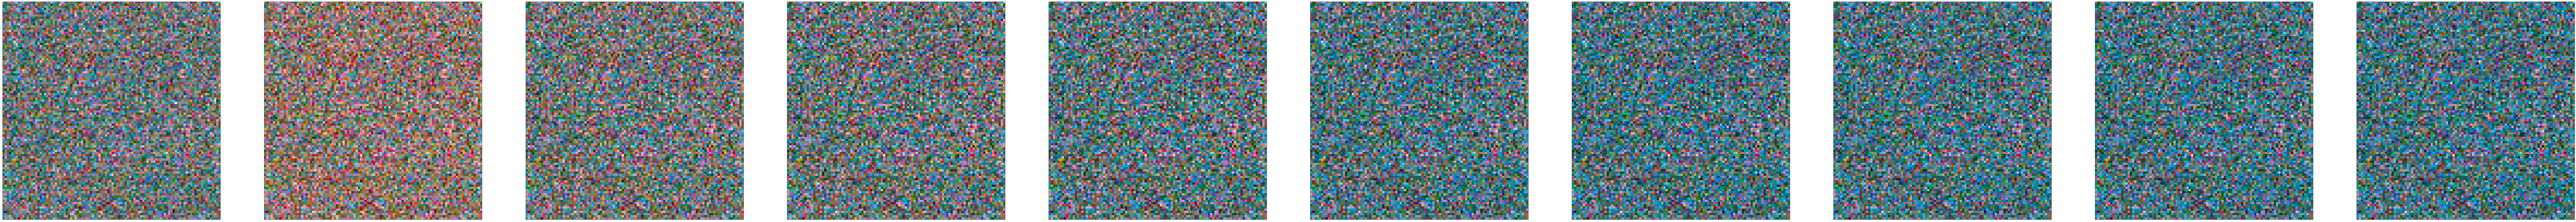

In [11]:
if not isinstance(results[0], list):
    results = [results]

num_rows = len(results)
num_cols = len(results[0])
fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)

for row_idx, row in enumerate(results):
    row = row
    for col_idx, img in enumerate(row):
        ax = axs[row_idx, col_idx]
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
print("X_0 is the last element displayed")

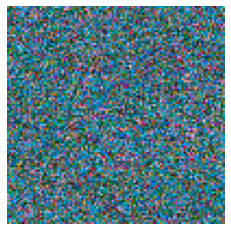

In [12]:
plt.axis('off')
plt.imshow(np.asarray(results[0][-1]))